# Exercise - Intro to Machine Learning
Note: This exercise closely follows the post by Scott Fortmann-Roe about bias-variance tradeoff (see references below). It is recommended that you think about each of the questions before referring to that essay.

In this exercise you will get familiar with a **non-parapmetric** learning algorithm called k-Nearest Neighbours (kNN), and will implement it. You will then analyse the bias-variance tradeoff and try to come up with the optimal kNN classifier for the given data.

For this exercise we will use hypothetical and artificial generated data.


## Implement k-Nearest Neighbours (kNN)

The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbour of the new data in the sample set.

For this task, assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

Implement a class called KNNClassifier and two methods:
- `fit`: should recieve the training data (an array of shape [n_samples, n_features]) and their labels (array of shape [n_samples]). 
- `predict`: should recieve a set of data (an array of shape [n_samples, n_features]) and **return** their predicted labels (array of shape [n_samples]).

Use simple Euclidean distance to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set. 

Use majority vote between all kNN of a point to predict its label. In case the vote of all kNN is tied, you may predict whichever label you wish.

You may look up [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for reference.



In [ ]:
import numpy as np

class kNNClassifier:
  def __init__(self, k_neighbors):
    self.n_neighbors = k_neighbors
    
  def fit(self, X, y):
    self.training_set = X
    self.training_lbl = y
    
  def predict(self, X):
    predictions = np.empty(X.shape[0], dtype=int)
    for s in range(X.shape[0]):
      predictions[s] = self._predict_one_sample(X[s])
    return predictions
    
  def score(self, X, y):
    pred = self.predict(X)
    mean_accuracy = sum(pred == y) / float(len(y))
    return mean_accuracy
  
  def _predict_one_sample(self, x):
    # 1) get labels of k nearest neighbours
    distances = np.sqrt(np.sum((self.training_set-x)**2, axis=1)) # Euclidean distance
    index_array = np.argsort(distances)
    knn_labels = self.training_lbl[index_array[0:self.n_neighbors]]

    # 2) apply majority vote to decide on the predicted label
    unique, counts = np.unique(knn_labels, return_counts=True)
    prediction = unique[np.argmax(counts)]
    
    return prediction

## Learn and evaluate kNN algorithm on artificial data
kNN is a **non-parametric** in the sense that no inner parameter of the model is learned by the sample training set (or maybe the number of parameters increases with the size of the sample set). However, the number of neighbours **k is considered a hyper-parameter**, and choosing the optimal value is choosing the balance between bias and variance as discussed in class.




### An applied example: voter party registration

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democrat voter.

Use the given function `generate_data(m)` to create m samples with m labels. The labels are created using the following function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

and then a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent unknown effect of features which are not measured. The sign of 0 is defined as 1 for this case.


Below is an example of generating 500 samples, and plotting them.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def true_boundary_voting_pred(wealth, religiousness):
  return religiousness-0.1*((wealth-5)**3-wealth**2+(wealth-6)**2+80)

def generate_data(m, seed=None):
  # if seed is not None, this function will always generate the same data
  np.random.seed(seed) 
  
  X = np.random.uniform(low=0.0, high=10.0, size=(m,2))
  y = np.sign(true_boundary_voting_pred(X[:,0], X[:,1]))
  y[y==0] = 1
  samples_to_flip = np.random.randint(0,m//10)
  flip_ind = np.random.choice(m, samples_to_flip, replace=False)
  y[flip_ind] = -y[flip_ind]
  return X, y

def plot_labeled_data(X, y, no_titles=False):
  republicans = (y==1)
  democrats = (y==-1)
  plt.scatter(X[republicans,0], X[republicans,1], c='r')
  plt.scatter(X[democrats,0], X[democrats,1], c='b')
  if not no_titles:
    plt.xlabel('Wealth')
    plt.ylabel('Religiousness')
    plt.title('Red circles represent Republicans, Blues Democrats')
    
  plt.xlim([0, 10]);
  plt.ylim([0, 10]);
  plt.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');


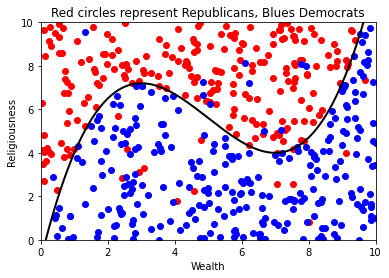

In [ ]:
# Play this several times to see different sampling sets
X, y = generate_data(m=500)
plot_labeled_data(X, y)



### 1. Analyse the properties of kNN
Generate multiple sample data sets of size 500 (use the given function above), and plot the decision plane for increasing values of k (e.g.: 1, 3, 5, 11, 21, 51, 99).

The decision plane should cover the range [0,10] for both axes, coloring the patches that would be classified as Republicans or Democrats in two colors. It should look something like [that](https://drive.google.com/open?id=1jMD7I9sWT4w4O48pjwSPCFL1NLLPo10j).

Answer the following questions:
- How is the decision plain affected from changes in the sample set, as a function of k?
- Can you describe when do you underfit or overfit the data? 
- How does the complexity of this model depends on k?


In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Colormap

def plot_2D_decision_plane(model, x_min, x_max, y_min, y_max, density=100):
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, density), np.linspace(y_min, y_max, density))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, colors=('xkcd:sky blue','xkcd:pale orange'))

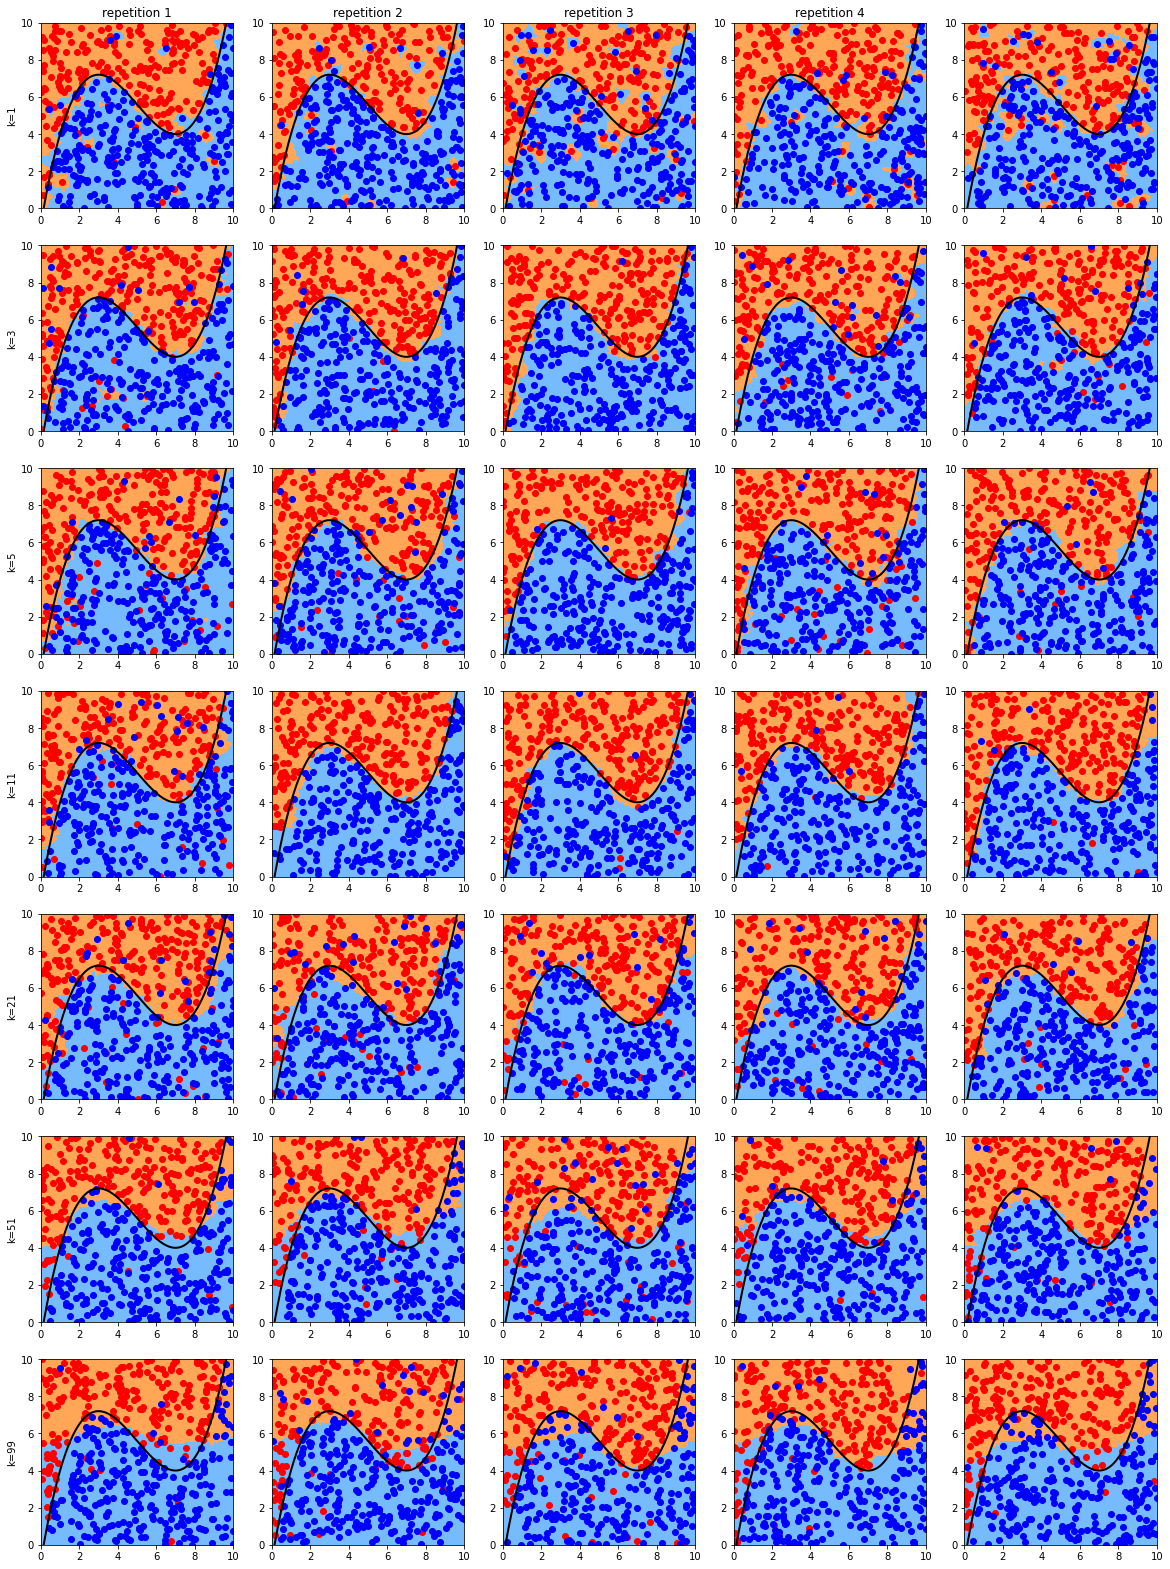

In [ ]:
K = [1,3,5,11,21,51,99]
num_repetitions = 5
plt.figure(figsize=(num_repetitions*4, len(K)*4))
plt_ind = 1
for k in K:
  knn = kNNClassifier(k)
  for i in range(num_repetitions):
    X, y = generate_data(m=500)
    knn.fit(X, y)
    plt.subplot(len(K), num_repetitions, plt_ind)
    if plt_ind < num_repetitions:
      plt.title('repetition ' + str(i+1))
    if plt_ind % num_repetitions == 1:
      plt.ylabel('k=' + str(k))
    plot_2D_decision_plane(knn, x_min=0, x_max=10, y_min=0, y_max=10)
    plot_labeled_data(X, y, no_titles=True)
    plt_ind += 1

Answers: 
- For small values of k, we can see that the decision plane varies quite a lot between different samples of the trainning set, where small opposite labeling patches appear in zones which should generally be labeled as republicans or democrats. Those patches are the result of the small pertubation in the labeling, and vary considerably in their position, based on the current sample set pertubation. For larger values of k, the usage of many neighbours applies a sort of averaging which reduces variance --- however, we can see that as the values of k becomes too large, the decision plane poorly follows the guiding separating function (plotted in a black line), and the bias increases. This is yet another evidence of the **bias-variance tradeoff**.

- Generally, a good fit for the data would match the generating boundary function (plotted as a black line). One can estimate that a good fit lies somewhere between k=5 and k=21, where for lower values we clearly overfit and data (matching even single random flips), and for larger value of k we clearly underfit, as although the opposite labeling patches are gone, the decision boundary is far from matching well the generating boundary function.

- Regarding the complexity of the algorithm as a function of k, the answer may be a bit paradoxical. You may think that the "simplest" model is achieved with k=1, as having more neighbors would result in more calculations that need to be made. This might be true from a computational standpoint, but from the model standpoint, the greater the variability of the resulting model, the greater its complexity. From this standpoint, it is clear that larger values of k result in lower model complexity, lacking the ability to match "fine details" in the sample set.


### 2. Finding the optimal k
Sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. Plot the train vs validation error for several k values, and choose the best k. Where do you underfit/overfit the data? Finally, estimate the generalization error of your chosen classifier using the test set.


In [ ]:
from sklearn.model_selection import train_test_split

# we set random_state and seed below, so that we fix sample set and its splitting, 
# so not every time we run this notebook a different data with different split
# would be generated (resulting in different results) - in short, for reproducibility

X, y = generate_data(m=1000, seed=0)

# Split the data into training and test sets
org_train_X, test_X, org_train_y, test_y = train_test_split(X, y, test_size=1/5.0, random_state=1234)
train_X, validation_X, train_y, validation_y = train_test_split(org_train_X, org_train_y, test_size=1/4.0, random_state=1234)

# verifying we got it right...
print(train_X.shape, validation_X.shape, test_X.shape, train_y.shape, validation_y.shape, test_y.shape)

(600, 2) (200, 2) (200, 2) (600,) (200,) (200,)


In [ ]:
K = range(1, 60, 2)

training_err = np.empty(len(K))
validation_err = np.empty(len(K))

for i in range(len(K)):
  knn = kNNClassifier(K[i])
  knn.fit(train_X, train_y)  
  training_err[i] = 1 - knn.score(train_X, train_y) 
  validation_err[i] = 1 - knn.score(validation_X, validation_y)


Optimal k (minimum validation error) is 5


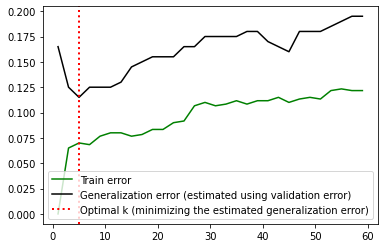

In [ ]:
opt_k = K[np.argmin(validation_err)]

plt.plot(K, training_err, 'g', label='Train error');
plt.plot(K, validation_err, 'k', label='Generalization error (estimated using validation error)');
plt.axvline(opt_k, color='r', linewidth=2, linestyle=':', label='Optimal k (minimizing the estimated generalization error)');

plt.legend(loc='lower right')
print('Optimal k (minimum validation error) is ' + str(opt_k))

In [ ]:
# Optimal model (based on current knowledge)
knn = kNNClassifier(opt_k)
knn.fit(org_train_X, org_train_y)
generalization_err = 1 - knn.score(test_X, test_y)
print('Estimated generalization error is: ' + str(generalization_err))

Estimated generalization error is: 0.10999999999999999


The plot above has a classical shape (only in reverse, since remember that lower k means a more complex model). **Right** to the optimal k (red line) the model **underfit** the data (approaching the optimal k both error rate reduce as the model better describes the data), while **left** to it we see a very clear **overfitting** (train error goes to zero, while generalization error increases dramatically).

However, it is important to note that the result of the optimal k and the beahviour of the error curves, may change if we are given a different sample set (or split it differently). One way to handle this is to sample much more data --- however, in most real world applications this is impossible, and in this case too, we assume the 1000 samples we got are all we have. In the next section we will try to reduce this variability using k-fold cross validation.

### 3. Using cross validation
This time, put the test data aside (0.2 of the data), and apply 5-fold CV on the remaining data to evaluate the performance of each k value. 
What is the size of the validation and train set now, in each CV iteration?
Did your final model selection change? Explain why.

In [ ]:
from sklearn.model_selection import KFold

def my_cross_val_score(model, X, y, cv):
  # there is no real reason to shuffle, the samples are already random
  kf = KFold(n_splits=cv) 
  scores = []
  for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test)) 
  return scores

def optimal_param_using_cross_val(model_class, param_vals, 
                                  cross_val_score_fn, num_folds, 
                                  X_train, y_train, X_test, y_test):
  # find optimal parameter using k-fold cross validation test
  validation_err = np.empty(len(param_vals))
  for i in range(len(param_vals)):
    model = model_class(param_vals[i])
    validation_err[i] = 1 - np.mean(cross_val_score_fn(model, X_train, y_train, cv=num_folds))
  
  opt_p = param_vals[np.argmin(validation_err)]
  print('Optimal parameter (minimum validation error) is ' + str(opt_p) +
        ' with an estimated generalization error of ' + str(np.min(validation_err)))
  
  plt.plot(param_vals, validation_err, 'k', label='Generalization error (estimated using validation error)');
  plt.axvline(opt_p, color='r', linewidth=2, linestyle=':', label='Optimal param (minimizing the estimated generalization error)');
  plt.legend(loc='upper right')
  
  # print the estimated generalization error on the test set
  model = model_class(opt_p)
  model.fit(X_train, y_train)
  generalization_err = 1 - model.score(X_test, y_test)
  print('Estimated generalization error on test set: ' + str(generalization_err))

Optimal parameter (minimum validation error) is 5 with an estimated generalization error of 0.09375
Estimated generalization error on test set: 0.10999999999999999


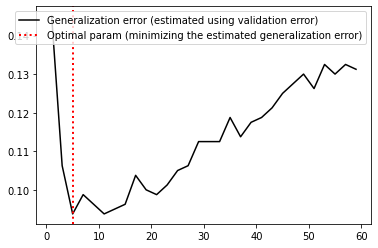

In [ ]:
optimal_param_using_cross_val(kNNClassifier, K, my_cross_val_score, 5, 
                              org_train_X, org_train_y, test_X, test_y)

We are using our train data which contains 800 points, and we are applying a 5-fold cross validation task, so the data is split in each iteration into $\frac{1}{5}$ for test, and $1-\frac{1}{5}=\frac{4}{5}$ for training. That is, in each split, 160 samples are used for evaluation (test), and 640 are used for estimation (train).

The final model selection did not change in this case. Is this the best k? Maybe, but due to our relatively small sample size and the potential complexity of this model, we will probably still get enough variablity even in this case to change the final outcome and shift the optimal value of k when different sample sets are generated, or even just different partitions of the data are created in the k-fold cross validation test (see below, "Comparison with `KNeighborsClassifier` and `cross_val_score` from `sklearn`").  

Generally, using k-fold cross validation gives us a more stable estimation of the generalization error rate (as it is averaged over several random partitions of the data into train and test). As we increase the number of folds in the cross validation test we will reduce the variance in the generalization error estimation task --- however, it is most likely that at the same time we will increase the bias of this task, making us believe the generalization error rate is lower than it actually is.

Below, we ran 10, 40, and 200-fold cross validation experiments. The results suggest that **the optimal k for in this case is probably 17**.

Optimal parameter (minimum validation error) is 15 with an estimated generalization error of 0.08874999999999988
Estimated generalization error on test set: 0.08999999999999997


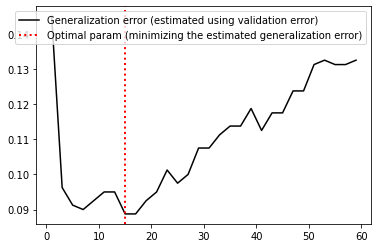

In [ ]:
optimal_param_using_cross_val(kNNClassifier, K, my_cross_val_score, 10, 
                              org_train_X, org_train_y, test_X, test_y)

Optimal parameter (minimum validation error) is 17 with an estimated generalization error of 0.0824999999999999
Estimated generalization error on test set: 0.08499999999999996


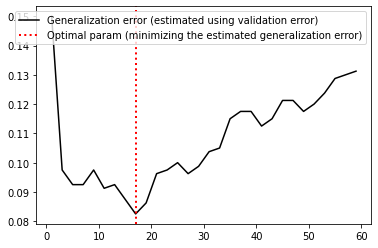

In [ ]:
optimal_param_using_cross_val(kNNClassifier, K, my_cross_val_score, 40, 
                              org_train_X, org_train_y, test_X, test_y)

Optimal parameter (minimum validation error) is 17 with an estimated generalization error of 0.08250000000000002
Estimated generalization error on test set: 0.08499999999999996


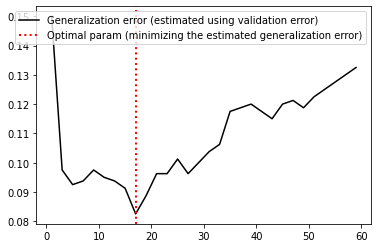

In [ ]:
optimal_param_using_cross_val(kNNClassifier, K, my_cross_val_score, 200, 
                              org_train_X, org_train_y, test_X, test_y)

#### Comparison with `KNeighborsClassifier` and `cross_val_score` from `sklearn`
As can be seen below, the `KNeighborsClassifier` returns the same results (although to be sure one might wish to set the `algorithm` parameter to 'brute' and not `auto`). However, the `cross_val_score` seems to divide the data a bit differently, as evident by the different results and different optimal k value we got in the 5-fold cross validation experiment.

That said, as we increase the fold, the difference in data division no longer effects the final result, and we got same results as using our own algorithm (again, the variance was reduced, but as we know already, the bias was probably increased).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

`KNeighborsClassifier` with **our own** `my_cross_val_score` function

Optimal parameter (minimum validation error) is 5 with an estimated generalization error of 0.09375
Estimated generalization error on test set: 0.10999999999999999


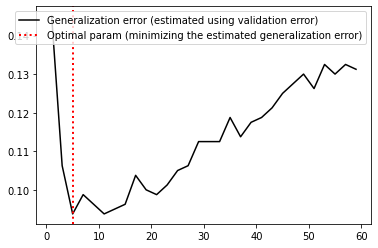

In [ ]:
optimal_param_using_cross_val(KNeighborsClassifier, K, my_cross_val_score, 5, 
                              org_train_X, org_train_y, test_X, test_y)

`KNeighborsClassifier` with `cross_val_score` function


Optimal parameter (minimum validation error) is 15 with an estimated generalization error of 0.09000000000000008
Estimated generalization error on test set: 0.08999999999999997


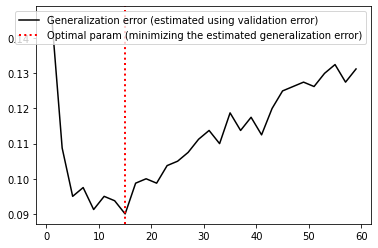

In [ ]:
optimal_param_using_cross_val(KNeighborsClassifier, K, cross_val_score, 5, 
                              org_train_X, org_train_y, test_X, test_y)

Optimal parameter (minimum validation error) is 15 with an estimated generalization error of 0.08499999999999996
Estimated generalization error on test set: 0.08999999999999997


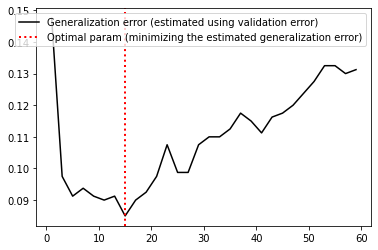

In [ ]:
optimal_param_using_cross_val(KNeighborsClassifier, K, cross_val_score, 10, 
                              org_train_X, org_train_y, test_X, test_y)

Optimal parameter (minimum validation error) is 17 with an estimated generalization error of 0.08250000000000013
Estimated generalization error on test set: 0.08499999999999996


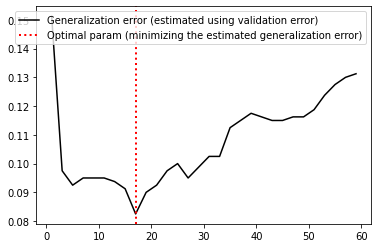

In [ ]:
optimal_param_using_cross_val(KNeighborsClassifier, K, cross_val_score, 40, 
                              org_train_X, org_train_y, test_X, test_y)

In [ ]:
optimal_param_using_cross_val(KNeighborsClassifier, K, cross_val_score, 200, 
                              org_train_X, org_train_y, test_X, test_y)

## References
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- http://scott.fortmann-roe.com/docs/MeasuringError.html
- http://scikit-learn.org/stable/modules/cross_validation.html
